# `"PMSM temperature dataset"`
## Problema di regressione

## DESCRIZIONE
Il [dataset](https://www.kaggle.com/wkirgsn/electric-motor-temperature) comprende diverse informazioni raccolte, durante alcuni test condotti su banco di prova, da sensori collegati ad un motore sincrono a magneti permanenti (permanent magnet synchronous motor, PMSM). Il PMSM utilizzato è un nuovo modello prototipale prodotto da una società tedesca e i dati sono stati collezionati dal dipartimento LEA della Paderborn University. **Il dataset è stato anonimizzato.**


I dati sono stati raccolti ad una frequenza di 2 Hz durante diverse sessioni di misurazione per un totale di 140 ore di test sul banco prova. Ogni sessione può essere distinta dal campo `profile_id` e può durare dall'una alle sei ore.

```
The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque. Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque. Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

Most driving cycles denote random walks in the speed-torque-plane in order to imitate real world driving cycles to a more accurate degree than constant excitations and ramp-ups and -downs would.
```



Le variabili più interessanti sono le temperature dello statore (``stator_*``), del rotore (``pm``), e la coppia sprigionata (``torque``). In particolare le ultime due informazioni sono generalmente di difficile ed economicamente onerosa misurazione su veicoli commerciali.

La capacità di stimare con precisione la temperatura del rotore aiuta gli ingegneri a costruire motori robusti ma più leggeri e a massimizzare le performance. Dall'altro lato una corretta stima della coppia espressa dal motore permette di controllare con maggiore precisione il motore, riducendo le perdite di potenza ed eventuali picchi di temperatura.

![PMSM](https://www.embitel.com/wp-content/uploads/2019/05/PMSM-Motor.png)

## Importazione del dataset

In [0]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
df = pd.read_csv('pmsm_temperature.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


**Dizionario**  
> _ambient_: temperatura ambiente misurata da un sensore termico posizionato vicino lo statore  
_coolant_: temperatura del liquido di raffreddamento (acqua) misurata in uscita dal motore  
_u\_d_: voltaggio della componente d   
_u\_q_: voltaggio della componente q  
_motor\_speed_: velocità di rotazione del motore  
_torque_: coppia indotta dalla corrente  
_i\_d_: corrente della componente d  
_i\_q_: corrente della componente q  
_pm_: temperatura superficiale del magnete permanente (permanent magnet) misurata con un'unità termografica ad infrarossi  
_stator\_yoke_: temperatura del giogo dello statore misurata con un sensore termico  
_stator\_tooth_: temperatura dei denti dello statore misurata con un sensore termico  
_stator\_winding_: temperatura dell'avvolgimento dello statore misurata con un sensore termico  
_profile\_id_: ogni sessione di misurazione possiede un unico ID. Ogni sessione è indipendente ed estremamente diversa dalle altre.

**Sulla base delle informazioni fornite, si decide di interpretare come variabili target la temperatura del rotore (`pm`) e la coppia sprigionata (`torque`)**

![PMSM](https://www.embitel.com/wp-content/uploads/2019/05/BLDC-Motor.gif)

In [0]:
df.head()

ambient   coolant       u_d  ...  stator_tooth  stator_winding  profile_id
0 -0.752143 -1.118446  0.327935  ...     -2.066143       -2.018033           4
1 -0.771263 -1.117021  0.329665  ...     -2.064859       -2.017631           4
2 -0.782892 -1.116681  0.332771  ...     -2.064073       -2.017343           4
3 -0.780935 -1.116764  0.333700  ...     -2.063137       -2.017632           4
4 -0.774043 -1.116775  0.335206  ...     -2.062795       -2.018145           4

[5 rows x 13 columns]

In [0]:
df.describe()

ambient        coolant  ...  stator_winding     profile_id
count  998070.000000  998070.000000  ...   998070.000000  998070.000000
mean       -0.003905       0.004723  ...       -0.003935      50.732001
std         0.993127       1.002423  ...        0.998343      22.073125
min        -8.573954      -1.429349  ...       -2.019973       4.000000
25%        -0.599385      -1.037925  ...       -0.725622      32.000000
50%         0.266157      -0.177187  ...        0.006536      56.000000
75%         0.686675       0.650709  ...        0.725660      68.000000
max         2.967117       2.649032  ...        2.653781      81.000000

[8 rows x 13 columns]

**Nessun valore mancante per le covariate disponibili**

## Analisi Sessioni

In [0]:
print(f'For testing the PMSM the team conducted {len(df.profile_id.unique())} sessions.\n')
sessions = df.profile_id.value_counts()
for num, data in zip(sessions.index, sessions.tolist()):
    print(f'Session {int(num):3d}\t\tData collected: {data:6d}\t\tHours of testing: {data/(2*60*60): 2.1f}')

For testing the PMSM the team conducted 52 sessions.

Session  20		Data collected:  43970		Hours of testing:  6.1
Session   6		Data collected:  40387		Hours of testing:  5.6
Session  65		Data collected:  40093		Hours of testing:  5.6
Session  66		Data collected:  36475		Hours of testing:  5.1
Session  27		Data collected:  35360		Hours of testing:  4.9
Session   4		Data collected:  33423		Hours of testing:  4.6
Session  58		Data collected:  33381		Hours of testing:  4.6
Session  56		Data collected:  33122		Hours of testing:  4.6
Session  53		Data collected:  32441		Hours of testing:  4.5
Session  79		Data collected:  31153		Hours of testing:  4.3
Session  44		Data collected:  26340		Hours of testing:  3.7
Session  70		Data collected:  25676		Hours of testing:  3.6
Session  62		Data collected:  25599		Hours of testing:  3.6
Session  30		Data collected:  23862		Hours of testing:  3.3
Session  80		Data collected:  23823		Hours of testing:  3.3
Session  74		Data collected:  23760		Hours of 


---

**Pur mancando un campo esplicativo specifico, dalla documentazione sembra che il dataset riporti ogni rilevazione in ordine cronologico**

> **Verifichiamolo!**

In [0]:
for val in df.profile_id.unique():
    idxs = df.query(f'profile_id == {val}').index
    check = (len(idxs) == (1 + idxs.max() - idxs.min()))
    print(f'Session {val}\t Data available: {len(idxs):6d}\t\tCheck result: {check}')

Session 4	 Data available:  33423		Check result: True
Session 6	 Data available:  40387		Check result: True
Session 10	 Data available:  15255		Check result: True
Session 11	 Data available:   7886		Check result: True
Session 20	 Data available:  43970		Check result: True
Session 27	 Data available:  35360		Check result: True
Session 29	 Data available:  21357		Check result: True
Session 30	 Data available:  23862		Check result: True
Session 31	 Data available:  15586		Check result: True
Session 32	 Data available:  20959		Check result: True
Session 36	 Data available:  22608		Check result: True
Session 41	 Data available:  16699		Check result: True
Session 42	 Data available:  16919		Check result: True
Session 43	 Data available:   8442		Check result: True
Session 44	 Data available:  26340		Check result: True
Session 45	 Data available:  17141		Check result: True
Session 46	 Data available:   2179		Check result: True
Session 47	 Data available:   2175		Check result: True
Session 48	 

**L'ipotesi sembra corretta, costruiamo allora un'altro campo**

In [0]:
idxs_min = []
for val in df.profile_id.unique():
    idxs_min.append(df.query(f'profile_id == {val}').index.min())
    
def inf_closest(x, l):
    return max(l, key=lambda v: v-x if v-x < 0 else np.nan)
    
df['time'] = pd.Series(df.index).apply(lambda x: 0 if x in idxs_min else x - inf_closest(x, idxs_min))

In [0]:
df.head()

ambient   coolant       u_d  ...  stator_winding  profile_id  time
0 -0.752143 -1.118446  0.327935  ...       -2.018033           4     0
1 -0.771263 -1.117021  0.329665  ...       -2.017631           4     1
2 -0.782892 -1.116681  0.332771  ...       -2.017343           4     2
3 -0.780935 -1.116764  0.333700  ...       -2.017632           4     3
4 -0.774043 -1.116775  0.335206  ...       -2.018145           4     4

[5 rows x 14 columns]

## Analisi Univariata e Multivariata

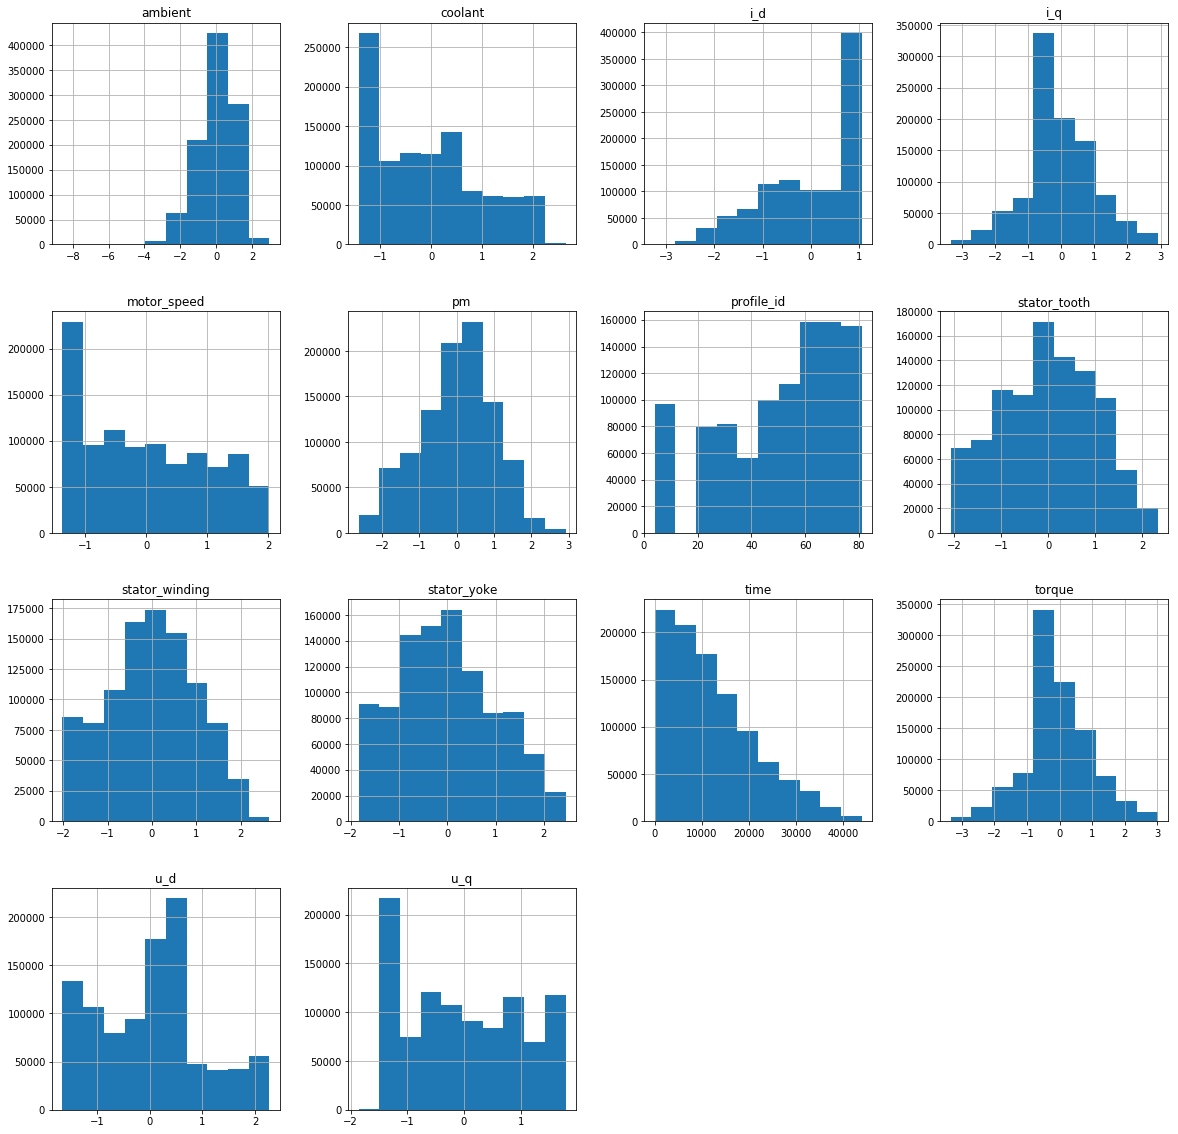

In [0]:
df.hist(figsize = (20,20))
plt.show()

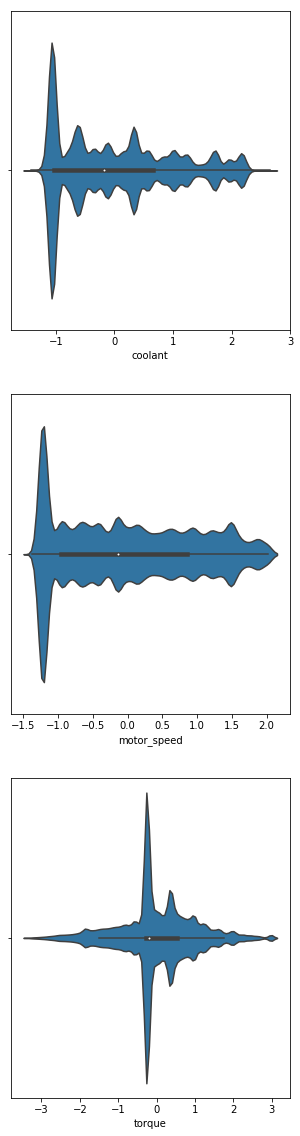

In [0]:
# Violin Plot
column = ['coolant', 'motor_speed', 'torque']
fig, axes = plt.subplots(nrows=3, figsize=(5,20))
fig.subplots_adjust(hspace=0.2)

for (ax, i) in zip(axes, column):
    sns.violinplot(x=df[i], ax=ax)
    plt.plot()

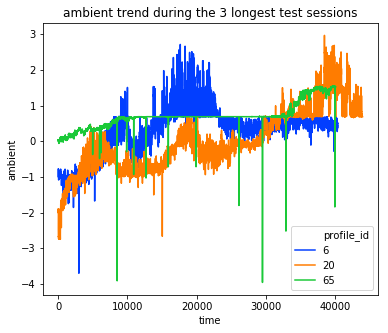

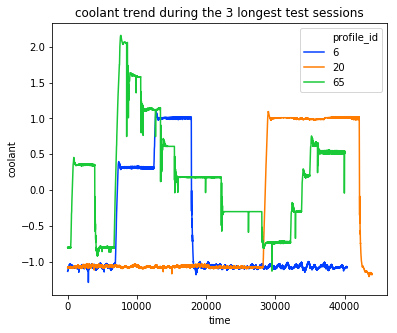

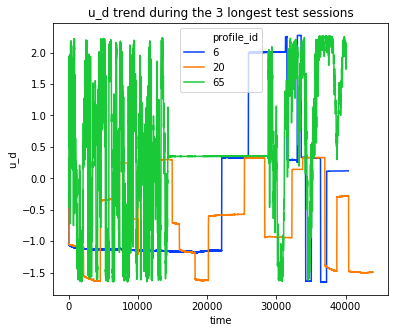

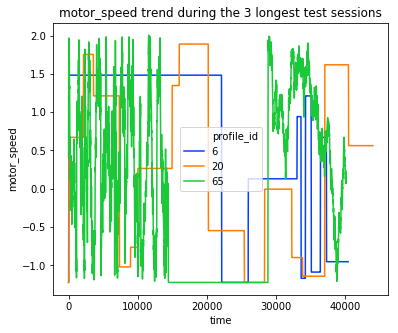

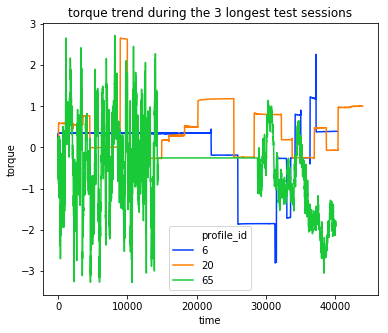

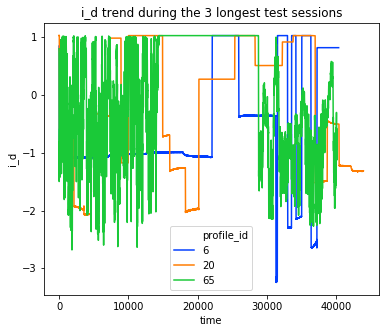

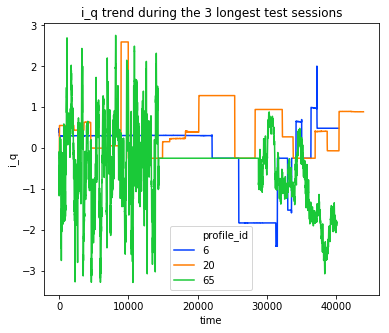

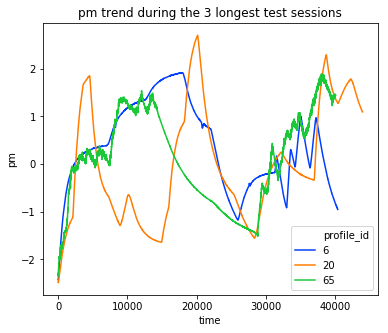

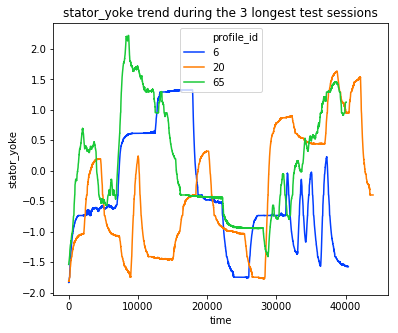

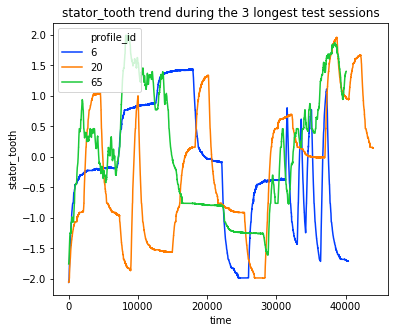

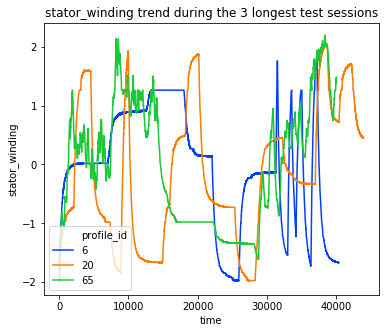

In [0]:
# Analisi temporale delle 3 sessioni più lunghe
columns = df.drop(columns=['profile_id', 'time']).columns

df_plot = df.query('profile_id in [20, 6, 65]')

for col in columns:
    plt.figure(figsize=(6, 5))
    sns.lineplot(x='time', 
                 y=col, 
                 hue='profile_id', 
                 data=df_plot, 
                 palette=sns.color_palette('bright', len(df_plot.profile_id.unique())))
    plt.title(f'{col} trend during the 3 longest test sessions')
    plt.show()

*   **La rilevazione della temperatura ambiente sembra avere picchi anomali**
*   Durante una delle tre sessioni è stata provata una configurazione particolare di alimentazione che probabilmente ha impedito al motore di generare coppia ("il campo `torque` è troppo costante durante questa fase"). Data la nomalizzazione la coppia non risulta avere valore nullo, ma può essere ipotizzato tale anche dal fatto che la temperatura dello statore (`pm`) è sempre calata nell'intervallo di tempo considerato.



### Analisi Temperatura Ambiente

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


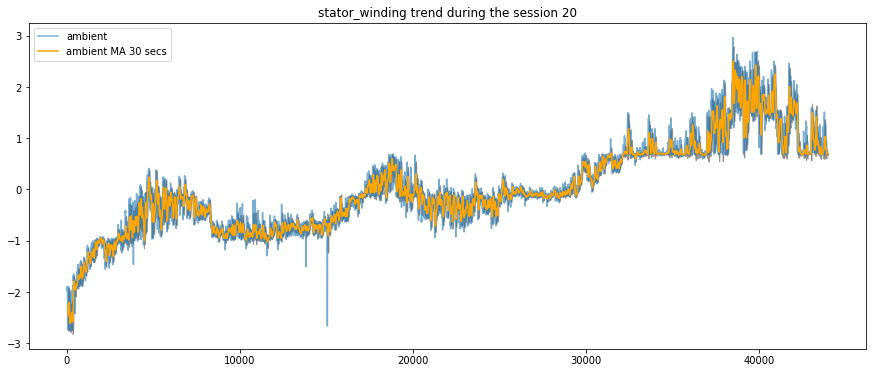

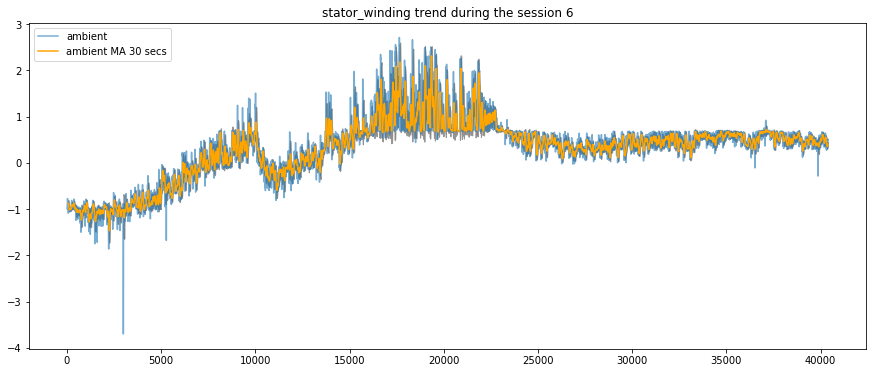

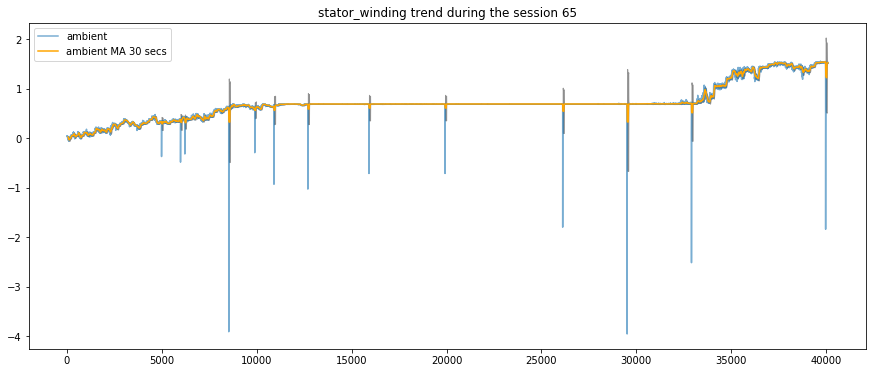

In [0]:
for session in [20, 6, 65]:
    data = df.query(f'profile_id == {session}')
    data['ambient_ma'] = data['ambient'].rolling(window=60).mean()
    data['ambient_std'] = data['ambient'].rolling(window=60).std()
    
    plt.figure(figsize=(15, 6))
    plt.plot(data.time, data.ambient, label='ambient', alpha=0.6)
    plt.plot(data.time, data.ambient_ma, label='ambient MA 30 secs', color='orange')
    plt.fill_between(data.time, data.ambient_ma + data.ambient_std, data.ambient_ma - data.ambient_std, color='grey', alpha=0.8)
    plt.legend(loc='upper left')
    plt.title(f'{col} trend during the session {session}')
    plt.show()

> **Completa tu!**

### Matrice di correlazione

**Correlazione di Pearson**

$$corr(X, Y) = \frac{cov(X, Y)}{\sqrt{var(X) var(Y)}}$$
dove
$$cov(X, Y) = \mathbb{E}[(X-\mathbb{E}[X])(Y-\mathbb{E}[Y])]$$

> Se $X$ e $Y$ sono indipendenti allora $cov(X, Y) = 0$ e $corr(X, Y) = 0$.

Si può dimostrare questa proprietà considerando che due variabili aleatorie si dicono indipendenti quando 
$$\mathbb{E}[XY]=\mathbb{E}[X]\mathbb{E}[Y]$$

*   Il coefficiente di correlazione è simmetrico: $corr(X, Y) = corr(Y, X)$
*   $corr(X, X) = 1$
*   Il coefficiente di correlazione è compreso tra -1 e 1; per tali valori si raggiunge rispettivamente il grado massimo di correlazione negativa e positiva
*   Se $|corr(X, Y)|=1$ allora vi è una dipendenza lineare tra $X$ e $Y$

**Per un campione**
$$r_{XY}=\frac{\sum_{i=1}^{N} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{N} (x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{N} (y_i - \bar{y})^2}}$$

Una interpretazione grafica: [Wikipedia](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#Geometric_interpretation)

**!! Attenzione a non confondere correlazione con causalità !!**
> `È colpa dei pompieri se ci sono tanti incendi! Più ce n'è in un luogo, più grande è l'incendio che scoppia!`

[Interessante conferenza in merito](https://youtu.be/cDhcmjCa7Pc)

In [0]:
corr = df.drop(columns=['profile_id', 'time']).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            mask=mask,
            cmap=cmap, 
            vmin=-1, 
            vmax=1, 
            annot=True,
            center=0,
            square=True,
            linewidths=.5, 
            cbar_kws={"shrink": .5})
plt.show()

#### Correlazione tra `i_q` e `torque`

In [0]:
rnd_sessions = random.sample(df.profile_id.unique().tolist(), 3)

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 6))

for i, session in enumerate(rnd_sessions):
    data = df.query(f'profile_id == {session}')

    sns.lineplot(x='time', 
                 y='i_q', 
                 data=data, 
                 color='r', 
                 label='i_q',
                 ax=axs[i],
                 alpha=0.6)
    
    sns.lineplot(x='time', 
                 y='torque', 
                 data=data, 
                 color='b', 
                 label='torque',
                 ax=axs[i],
                 alpha=0.6)
    
    axs[i].set_title(f'Session {session}', fontsize=14)
    axs[i].set_xlabel('')
    
plt.tight_layout()
plt.show()

> **È inutile sviluppare un modello di machine learning per predire la coppia sprigionata!**

**Conviene concentrarsi solo sulla temperatura del rotore**

# FEATURE BOX HILTON

## Training & Validation

In [0]:
import warnings
warnings.filterwarnings('ignore')

from graphviz import Source
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedKFold

### (1) Feature pre-processing

**I dati sono già stati normalizzati tra -3 e +3**

In [0]:
df.drop(columns=['torque'], inplace=True)

### (2) Partizionamento del dataset & Definizione del perimetro

**Definiamo il dataset che sarà modellizzato**

In [0]:
X = df.drop(columns=['pm'])
y = df['pm']

# Train set / Test set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

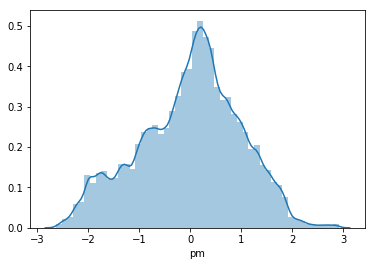

In [0]:
sns.distplot(y_train, rug=False)
plt.show()

### (3) Definizione delle metriche di interesse

> **Scarto quadratico medio** (MSE)
$$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_i-\hat{y}_i)^2$$

> **Scarto medio assoluto** (MAE)
$$MAE = \frac{1}{N}\sum_{i=1}^{N}|y_i-\hat{y}_i|$$

> **Scarto quadratico medio logaritmico** (MSLE)
$$MSLE = \frac{1}{N}\sum_{i=1}^{N}\left(\log(1 + y_i) -\log(1+\hat{y}_i\right)^2$$
$$MSLE = \frac{1}{N}\sum_{i=1}^{N}\left[\log\left(\frac{1 + y_i}{1+\hat{y}_i}\right)\right]^2$$

> **Scarto percentuale assoluto medio** (MAPE)
$$MAPE = \frac{1}{N}\sum_{i=1}^{N}\frac{|y_i-\hat{y}_i|}{y_i}$$

---

> **Coefficiente di determinazione** ($R^2$)
$$R^2 = 1 - \frac{\sum_{i=1}^{N}(y_i-\hat{y}_i)^2}{\sum_{i=1}^{N}(y_i-\bar{y}_i)^2}$$

> **Explained Variance** ($\text{ex_Var}$)
$$\text{ex_Var} = 1 - \frac{var(y-\hat{y})}{var(y)}$$
$$\text{ex_Var} = 1 - \frac{\sum_{i=1}^{N} \left(r_i^2 - \bar{r_i}\right)}{\sum_{i=1}^{N} \left(y_i^2-\bar{y}_i\right)}$$
con $r_i = y_i-\hat{y}_i$


In [0]:
def reg_report(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print('REGRESSION REPORT')
    print(f'MSE  : {mse:.4f}')
    print(f'RMSE : {np.sqrt(mse):.4f}')
    print(f'MAE  : {mean_absolute_error(y_test, y_pred):.4f}')
    print(f'R2   : {r2_score(y_test, y_pred):.2%}')
    print(f'explained_variance: {explained_variance_score(y_test, y_pred):.4f}')

### (4) Dummy Model
Prima di sviluppare algoritmi complessi è buona pratica sviluppare algoritmi estremamente banali così da poter disporre di un benchmark per le successive migliorie

In [0]:
strategy = 'mean'
dummy_model = DummyRegressor(strategy=strategy)

dummy_model.fit(X_train, y_train)
reg_report(dummy_model, X_test, y_test)

REGRESSION REPORT
MSE  : 0.9924
RMSE : 0.9962
MAE  : 0.7965
R2   : -0.00%
explained_variance: 0.0000


### Tecniche "avanzate" di validazione

> Esistono diverse tecniche avanzate di validazione tra qui la **k-fold cross validation** e sue varianti.\
[Qui](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) per maggiori dettagli.

![Kfold](https://www.researchgate.net/profile/Fabian_Pedregosa/publication/278826818/figure/fig10/AS:614336141750297@1523480558954/The-technique-of-KFold-cross-validation-illustrated-here-for-the-case-K-4-involves.png)


In [0]:
def cross_valid_report(model, X, y, model_type):  
    # Evaluate scores from CV
    scores = cross_val_score(model, 
                             X, 
                             y, 
                             scoring='neg_mean_squared_error',
                             cv=RepeatedKFold(n_splits=5, n_repeats=5))
    # This leads to MSE scores
    scores *= -1
    
    cross_valid_type = 'RepeatedKFold'
        
    plt.figure(figsize=(7, 5))
    
    hist, bins, bars = plt.hist(scores, bins='auto', align='left')
    plt.grid(axis='y', alpha=0.75)
    
    # Fix bar alignment
    plt.xticks(bins[:-1])
    
    plt.axvline(x=scores.mean(), color='k', linestyle='--', linewidth=1)
    plt.errorbar(x=scores.mean(), y=0.8, xerr=scores.std(), fmt='o', color='k')
    
    plt.suptitle(f'{cross_valid_type} ({len(scores)} folds) with {model_type}', fontsize=16)
    plt.title(f'Scores (MSE) mean={scores.mean():.3f} +/- {scores.std():.3f} (1 s.d.)', fontsize=14)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()
    
    return scores

In [0]:
# Verify model stability
# for the dummy model
cross_valid_report(dummy_model, X_train, y_train, model_type=f'DummyClassifier ({strategy})');

**Per l'ottimizzazione degli iper-parametri**

In [0]:
def search_cv_report(model):
    print(f'Best model parameters: {model.best_params_}\n')
    print('K-Fold Validation')
    print('\tmean_test_score : {:6.2%}'.format(model.cv_results_['mean_test_score'][model.best_index_]))
    print('\tstd_test_score  : {:6.2%}'.format(model.cv_results_['std_test_score'][model.best_index_]))

## Elastic Net

> **Regolarizzazione**: [Ridge, Lasso, Elastic](https://en.wikipedia.org/wiki/Lasso_(statistics)#Geometric_interpretation)

![L1 L2 Regularization](https://i.stack.imgur.com/A9yFq.png)

### (5) Model Training [Elastic Net]

You can also use [ElasticNetCV](https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.ElasticNetCV.html).

In [0]:
elastic_net = ElasticNet()

hyperparameters = {'alpha': np.linspace(0., 10., num=10),
                   'l1_ratio': np.linspace(0., 1., num=5)}

random_search = RandomizedSearchCV(elastic_net,
                                   hyperparameters, 
                                   n_iter=10,
                                   cv=5,
                                   refit=True,
                                   n_jobs=-1,
                                   verbose=1)

In [0]:
%%time
# Train and store the best model
elastic_model = random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.2min finished


CPU times: user 43.9 s, sys: 1.19 s, total: 45.1 s
Wall time: 5min 36s


### (6) Model Validation [Elastic Net]

**Yellow Brick**: una libreria per lo studio dei risultati di un classificatore o regressore

In [0]:
#from yellowbrick.regressor import PredictionError, ResidualsPlot

In [0]:
# Validate performance
search_cv_report(elastic_model)

Best model parameters: {'l1_ratio': 0.0, 'alpha': 0.0}

K-Fold Validation
	mean_test_score : 77.88%
	std_test_score  :  0.11%


In [0]:
# Verify model stability
# for the logistic regression model
cross_valid_report(elastic_model.best_estimator_, X_train, y_train, model_type='Elastic Net');

In [0]:
# Test
print(f'Test R2 Score: {elastic_model.score(X_test, y_test):.1%}')

Test R2 Score: 77.8%


In [0]:
reg_report(elastic_model, X_test, y_test)

REGRESSION REPORT
MSE  : 0.2201
RMSE : 0.4692
MAE  : 0.3598
R2   : 77.82%
explained_variance: 0.7782


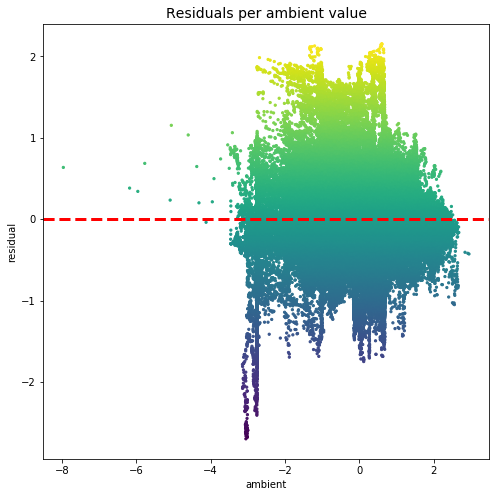

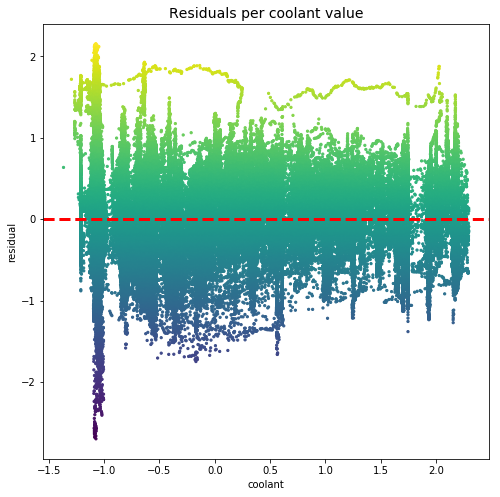

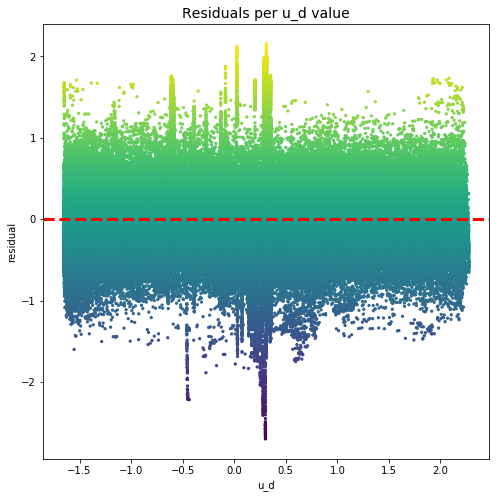

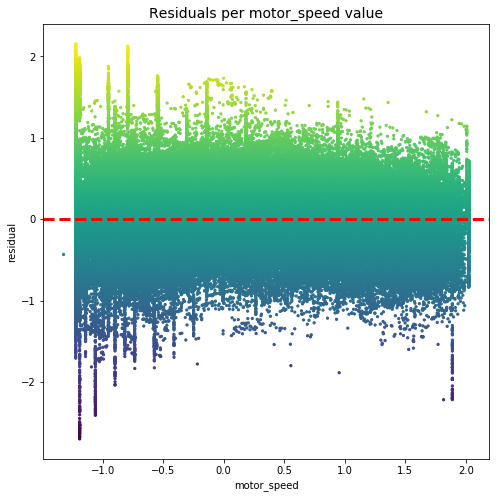

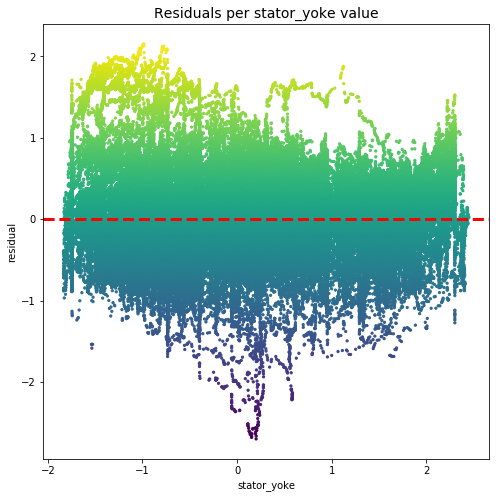

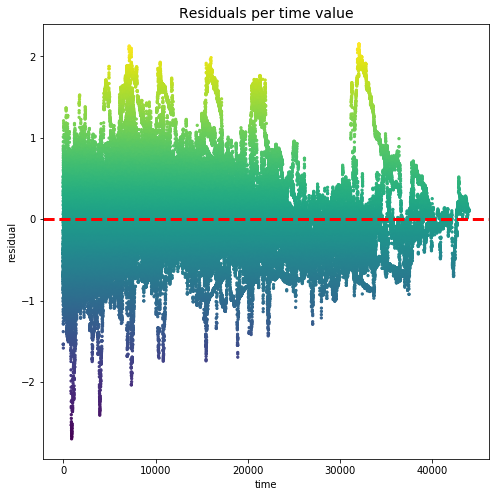

In [0]:
y_pred = elastic_model.predict(X_test)

df_residuals = pd.DataFrame({'y_truth': y_test, 'y_pred': y_pred})
df_residuals['residuals'] = df_residuals.y_truth - df_residuals.y_pred

for col in X_test.columns:
    plt.figure(figsize=(8, 8))    
    plt.scatter(x=X_test[col], y=df_residuals.residuals, c=df_residuals.residuals, marker='o', s=5, cmap='viridis')
    plt.axhline(0, c='r', ls='--', lw=3)
    plt.xlabel(col)
    plt.ylabel('residual')
    plt.title(f'Residuals per {col} value', fontsize=14)
    plt.show()

### (7) Worst Predictions Analysis [Elastic Net]

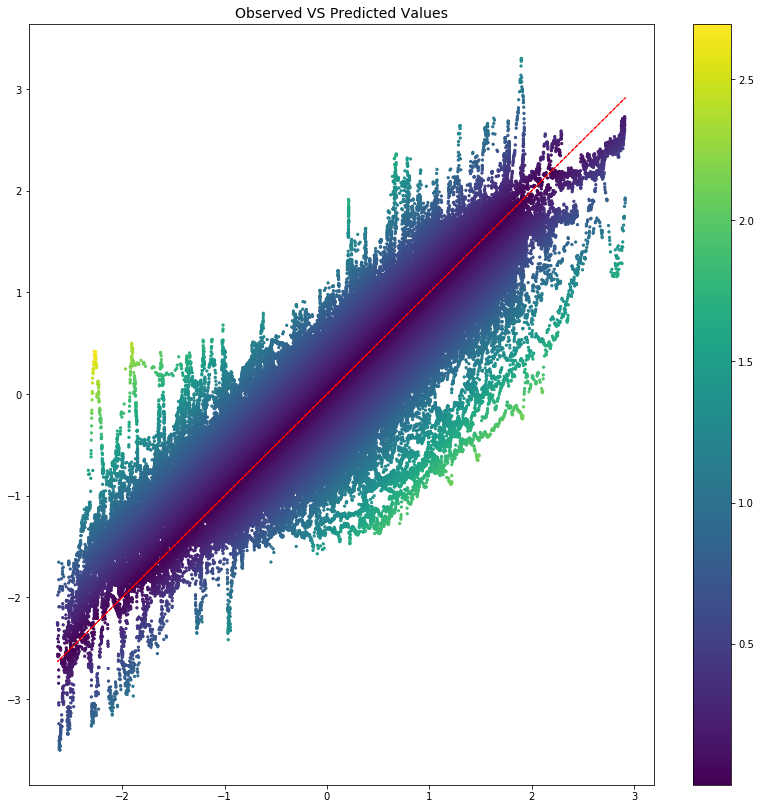

In [0]:
#Identify worsts predictions
def get_worst_pred(model, X, y):
    y_pred = model.predict(X)
    data = pd.DataFrame({'y_pred': y_pred}, index=X.index)
    data['y_truth'] = y
    data['abs_residual'] = (data.y_truth - data.y_pred).abs()

    data.sort_values(by=['abs_residual'], ascending=False, inplace=True)
    
    plt.figure(figsize=(14, 14))    
    plt.scatter(x=data.y_truth, y=data.y_pred, c=data.abs_residual, marker='o', s=5, cmap='viridis')
    plt.plot(data.y_truth, data.y_truth, c='r', ls='--', lw=1)
    clb = plt.colorbar()
    clb.set_label('abs(residual)')
    plt.title('Observed VS Predicted Values', fontsize=14)
    plt.show()
    
    return data

df_worst_pred = get_worst_pred(elastic_model, X_test, y_test)

In [0]:
df_worst_pred.head(10)

y_pred   y_truth  abs_residual
258952  0.423084 -2.273389      2.696473
258979  0.418599 -2.259234      2.677833
258978  0.405993 -2.260374      2.666367
258951  0.388286 -2.273273      2.661558
258984  0.381746 -2.260026      2.641772
258961  0.367910 -2.266541      2.634450
258976  0.371900 -2.261074      2.632974
258985  0.361956 -2.258404      2.620360
258962  0.346002 -2.266537      2.612539
258986  0.350323 -2.258841      2.609164

**Check features for worst predicted points**

In [0]:
# Given the filter above (for 1 or 0 errors), show the worst offenders
index_to_debug = df_worst_pred.index
points_to_debug = X_test.loc[index_to_debug].head(10)
points_to_debug.style.background_gradient(cmap='summer', low=2).set_caption('For worsts errors, show the features we use')

**Example of debugging**

In [0]:
# Example of debugging
point_to_debug = X_test.loc[index_to_debug[0]]
print('Debugging:', point_to_debug, 
      'with scores:', df_worst_pred.loc[point_to_debug.name], 
      sep='\n\n')

Debugging:

ambient            -3.052123
coolant            -1.074630
u_d                 0.302469
u_q                -1.185649
motor_speed        -1.189957
i_d                 1.013950
i_q                -0.091440
stator_yoke         0.200046
stator_tooth        0.883080
stator_winding      1.338116
profile_id         36.000000
time              907.000000
Name: 258952, dtype: float64

with scores:

y_pred          0.423084
y_truth        -2.273389
abs_residual    2.696473
Name: 258952, dtype: float64


### (8) Model vs Dummy Classifier [Elastic Net]

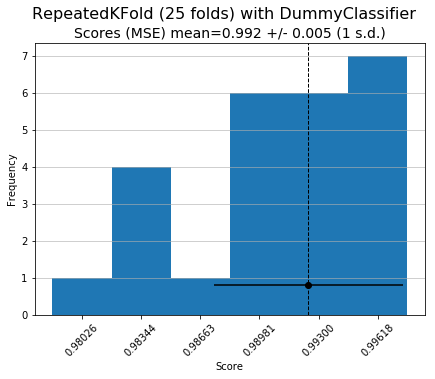

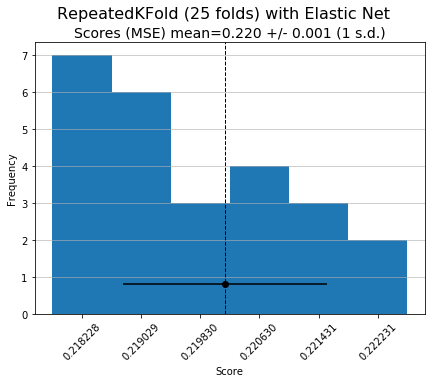

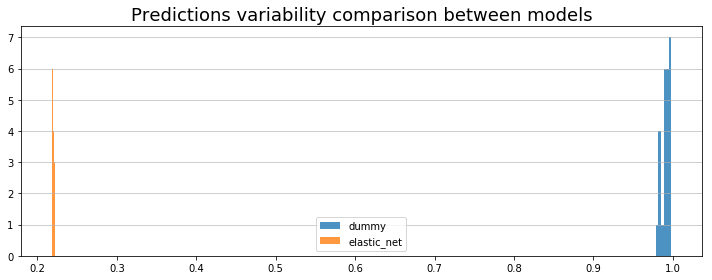

In [0]:
scores = {'dummy': cross_valid_report(dummy_model, X_test, y_test, model_type=f'DummyClassifier'),
          'elastic_net': cross_valid_report(elastic_model.best_estimator_, X_test, y_test, model_type=f'Elastic Net')}

df_scores = pd.DataFrame(scores)


# Plot scores for every model
plt.figure(figsize=(10, 4))
colors = plt.rcParams["axes.prop_cycle"]()

# A subplot for every label
for i, col in enumerate(df_scores.columns):
    tmp = df_scores[col]

    # Histogram
    plt.hist(tmp, 
             bins='auto',
             align='left',
             label=f'{col}',
             color=next(colors)['color'], 
             alpha=0.8)

plt.grid(axis='y', alpha=0.75)
plt.title(f'Predictions variability comparison between models', fontsize=18)
plt.legend(loc='auto')
plt.tight_layout()
plt.show()

## Regression Tree

**Classification And Regression Trees (CART)**

L'idea è di partizionare lo spazio delle covariate in modo tale ad ogni regione individuata possa essere assegnato un semplice modello. I CART possono essere visti come una combinazione di molti modelli in cui, ad un determinato punto $\mathbf{x}\in\mathcal{X}$, soltanto uno di essi è responsabile dell'effettiva previsione.

Il processo per cui si sceglie quale modello utilizzare per fornire la previsione in quel dato punto può essere descritta come un *processo decisionale sequenziale*. I CART sono un esempio di questa metodologia, ma ne esistiono anche altre come ID3 o C4.5.

I CART si basano su un processo ricorsivo in cui ad ogni step lo spazio delle variabili esplicative $\mathcal{X}$ è separato in due regioni i cui spigoli sono allineati con gli assi: ciò significa che una delle covariate è utilizzata come discriminante per distinguere le due porzioni di $\mathcal{X}$. Ad esempio si seleziona $t$, valore di una covariata $x_i$ tale che
$$\mathcal{X} = \{x_i < t\} \cap \{x_i \ge t\} = \mathcal{X}_1 \cap \mathcal{X}_2$$
poi, con $s$ valore di $x_j$,
$$\mathcal{X} = \mathcal{X}_1 \cup (\mathcal{X}_2 \cap \{x_j < s\}) \cup (\mathcal{X}_2 \cap \{x_j \ge s\})$$
e così via.

All'interno di ogni regione individuata costruiamo un modello distinto per la variabile target.
Ad esempio, nel caso più semplice, in un compito di regressione prevediamo un valore costante; per un compito di classificazione associamo alla regione una specifica probabilità per una data classe. Questo è esattamente ciò che accade nelle **foglie** dei CART.


Questa interpretazione vale anche per i livelli superiori dell'albero decisionale, in cui si può affermare che per una data regione di $\mathcal{X}$ il modello predittivo utilizzato è un altro CART.

Un'importante proprietà dei CART è che sono facilmente interpretabili in quanto per una persona sono equivalenti ad un processo decisionale.

**Questo tipo di decision trees non sono graphical models**

![Regression Tree](https://gdcoder.com/content/images/2019/05/Screen-Shot-2019-05-17-at-00.09.26.png)

**Training**

Allenare un modello CART significa determinare la struttura dell'albero, incluse quali variabili esplicative utilizzare ad ogni **nodo** e quali valori di essa scegliere per costruire il criterio di separazione (*split criterion*). Risulta inoltre necessario associare ad ogni regione dello spazio delle covariate il rispettivo valore della variabile target previsto.

Per definire una regola che guidi la definizione dei criteri di separazione occorre definire una *risk function*.
Nel caso di regression tree si usa generalmente lo scarto quadratico medio (MSE) o una misura della deviazione standard: per problemi di classificazione nella pratica si usa o l'indice di Gini o l'entropia (che è equivalente a quanto si ottiene applicando la stima tramite massima verosimiglianza, vedi reg. logistica).

Analizziamo il caso di un albero di regressione con training set $\mathcal{D}=\left\{(\mathbf{x}_i, y_i) \right\}_{i=1,\dots, N}$ e $\mathbf{x_i} = (x_1, \dots, x_d)$. Se il partizionamento dello spazio delle covariate fosse noto, potremmo minimizzare la *funzione di rischio* (assunta come MSE) su $\mathcal{D}$, per la specifica regione, semplicemente prendendo la media delle osservazioni di $Y$ sui punti che ricadono in quella regione dello spazio.

Sia $\mathcal{R}$ una regione di $\mathcal{X}$, allora
$$\hat{y}_{\mathcal{R}} = \frac{1}{N_\mathcal{R}} \sum_{\mathbf{x}_i \in \mathcal{R}} y_i$$

Per determinare la struttura dell'albero, e quindi le regioni di $\mathcal{X}$, supponiamo di fissare il numero di nodi. Risulterebbe computazionalmente troppo oneroso provare contemporaneamente qualsiasi combinazione possibile di covariata-valore per ogni nodo, valutando poi l'albero migliore. Per questo motivo si utilizza una tecnica di **greedy optimization** in cui si costruisce l'albero a partire da un unico nodo, si individua un criterio di separazione, e si procede poi aggiungendo nodi ai rami appena prodotti facendo crescere l'albero.
Ad ogni step si possono individuare diversi criteri di separazione, dipendenti sia dalla variabile esplicativa scelta che dal treshold. Per ogni criterio lo spazio delle variabili esplicative è ulteriormente frammentato e per le due regioni di $\mathcal{X}$ così ottenute si determinano le previsioni. Esistono algortmi che provano ogni combinazione possibile per quel nodo, o altri che svolgono ricerche "semplificate" (al costo dell'aggiunta di nuovi iper-parametri). Lo split criterion scelto è quello che garantisce la maggiore diminuzione della risk function: la maggiore differenza tra il MSE prima del nodo e quello derivante dalla somma delle sue foglie. Tale differenza viene detta anche **cost of split**.

La costruzione/profondità dell'albero può continuare finché ogni regione di $\mathcal{X}$ contiene un solo datapoint, cioé fino a che l'albero ha foglie che "contengono" un solo punto.

La capacità dei CART di raggiungere una simile granularità porta però al rischio di overfitting. Per questo motivo si applica la tecnica del **pruning** (potatura) delle foglie. Essa consiste nel fermare il processo di eliminazione delle foglie e dei nodi che raggiungono una profondità troppo elevata. Diversi possono essere i criteri di pruning, si può basare sul numero massimo di nodi, sul numero minimo di punti per regione di $\mathcal{X}$ e così via.

Sia $T$ una foglia che si riferisce a $\mathcal{R}_k$ regione di $\mathcal{X}$ e $|T|$ il suo nodo (la "profondità"). La risk function in $T$ vale
$$Q_{\mathcal{R}_k}(T) = \sum_{\mathbf{x}_i \in \mathcal{R}_k} \left(y_i - \hat{y}_{\mathcal{R}_k}\right)^2$$
dove per evitare ambiguità è stata cambiata la notazione. Il criterio di pruning si può scrivere allora come
$$C(T) = \sum_{k=0}^{|T|} Q_{\mathcal{R}_k}(T) + \lambda |T|$$

**Per come sono costruiti i CART, la restrizione più forte è che i criteri di separazione si basano su partizioni allineate a uno degli assi di $\mathcal{X}$.**

Queste condizioni possono essere rilassate a spese dell'interpretabilità dei modelli, ad esempio permettendo che lo split sia funzione di più varaibili esplicative combinate tra loro.

![CART predictions](https://cambridgecoding.files.wordpress.com/2016/01/regtree2.png?w=1165)

Da Wikipedia:

**Advantages of CART**

* Simple to understand, interpret, visualize.
* Decision trees implicitly perform variable screening or feature selection.
* Can handle both numerical and categorical data. Can also handle multi-output problems.
* Decision trees require relatively little effort from users for data preparation.
* Nonlinear relationships between parameters do not affect tree performance.

**Disadvantages of CART**

* Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting.
* Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This is called variance, which needs to be lowered by methods like bagging and boosting.
* Greedy algorithms cannot guarantee to return the globally optimal decision tree. This can be mitigated by training multiple trees, where the features and samples are randomly sampled with replacement.
* Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the data set prior to fitting with the decision tree.

### (5) Model Training [Regression Tree]

In [0]:
reg_tree = DecisionTreeRegressor()

hyperparameters = {'max_depth': np.arange(1., 31.),
                   'min_samples_split': np.linspace(5, 15, num=3).astype('int'),
                   'min_samples_leaf': np.linspace(5, 15, num=3).astype('int')}

random_search = RandomizedSearchCV(reg_tree,
                                   hyperparameters, 
                                   n_iter=10,
                                   cv=5,
                                   refit=True,
                                   n_jobs=-1,
                                   verbose=1)

In [0]:
%%time
# Train and store the best model
tree_model = random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.8min finished


CPU times: user 20.9 s, sys: 297 ms, total: 21.2 s
Wall time: 7min 9s


### (6) Model Validation [Regression Tree]

**Yellow Brick**: una libreria per lo studio dei risultati di un classificatore o regressore

In [0]:
#from yellowbrick.regressor import PredictionError, ResidualsPlot

In [0]:
# Validate performance
search_cv_report(tree_model)

Best model parameters: {'min_samples_split': 15, 'min_samples_leaf': 5, 'max_depth': 30.0}

K-Fold Validation
	mean_test_score : 99.89%
	std_test_score  :  0.00%


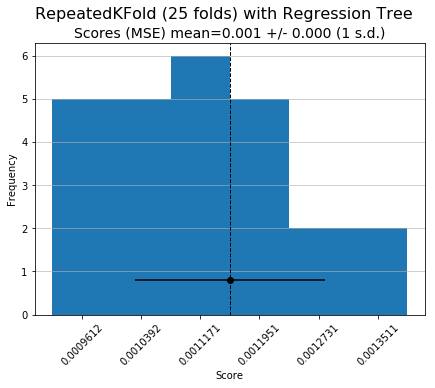

In [0]:
# Verify model stability
# for the logistic regression model
cross_valid_report(tree_model.best_estimator_, X_train, y_train, model_type='Regression Tree');

In [0]:
# Test
print(f'Test R2 Score: {tree_model.score(X_test, y_test):.1%}')

Test R2 Score: 99.9%


In [0]:
reg_report(tree_model, X_test, y_test)

REGRESSION REPORT
MSE  : 0.0009
RMSE : 0.0296
MAE  : 0.0066
R2   : 99.91%
explained_variance: 0.9991


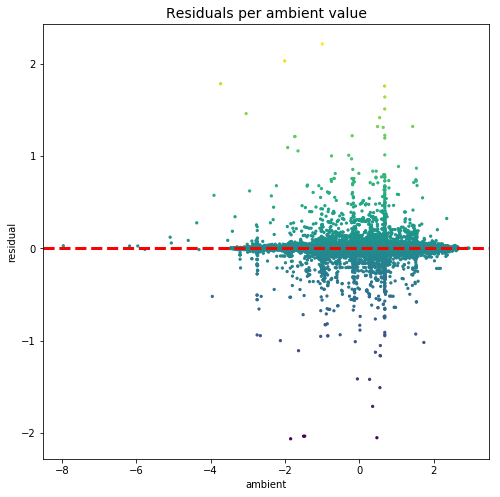

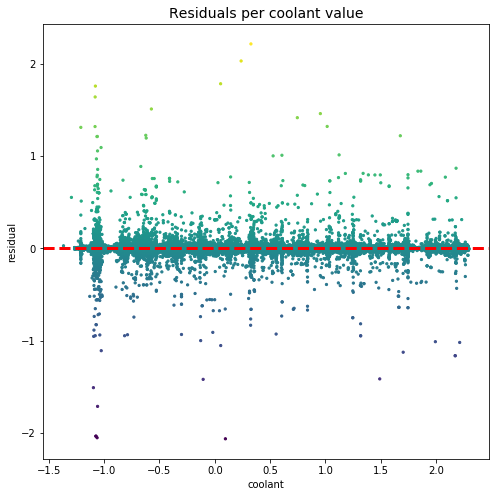

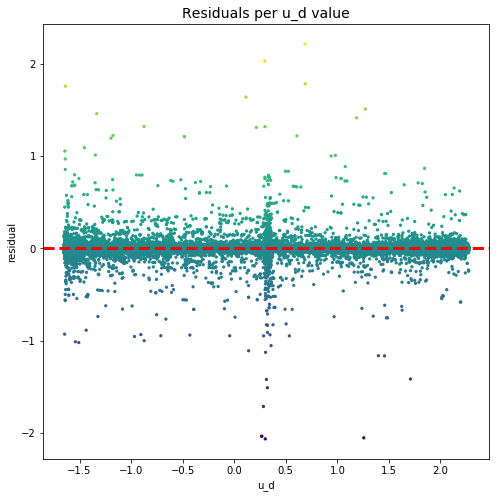

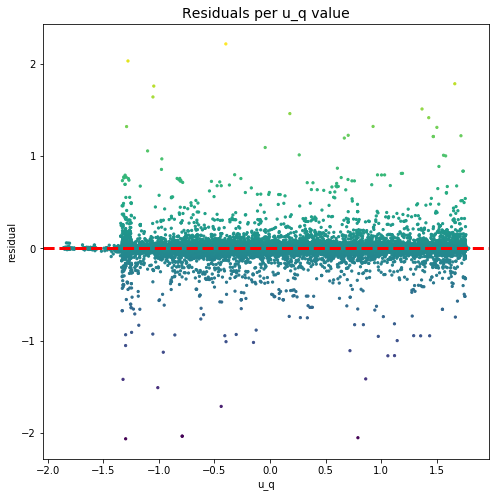

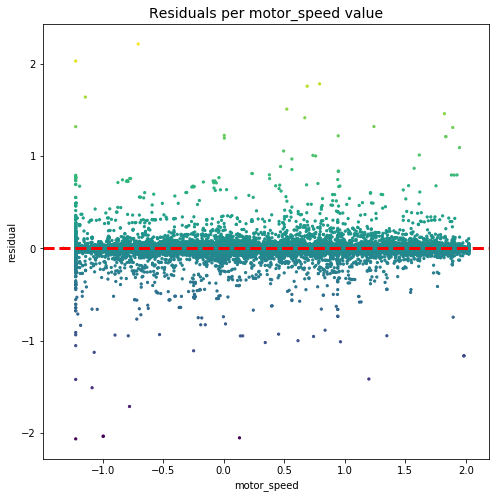

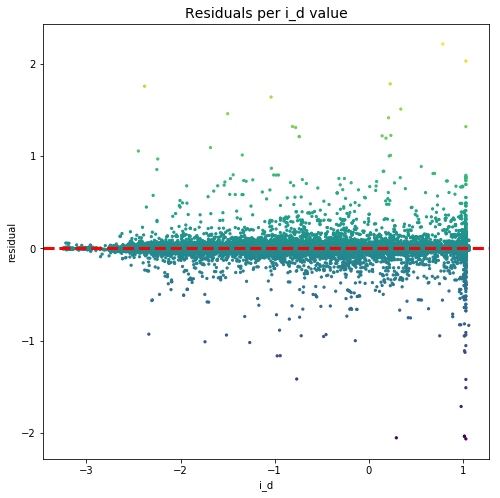

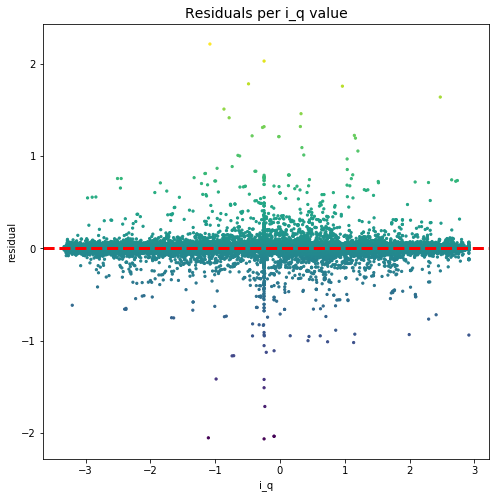

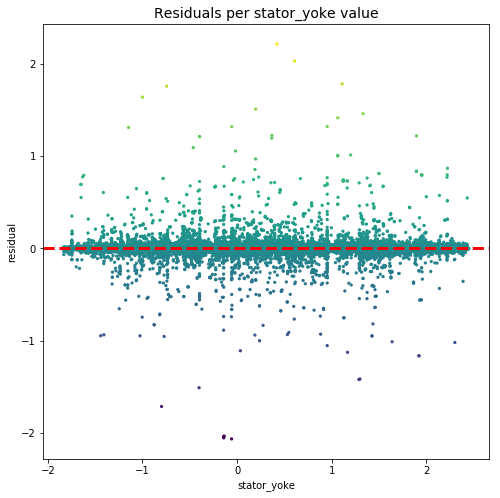

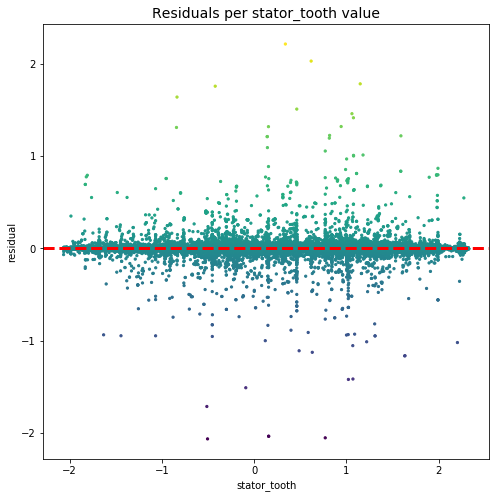

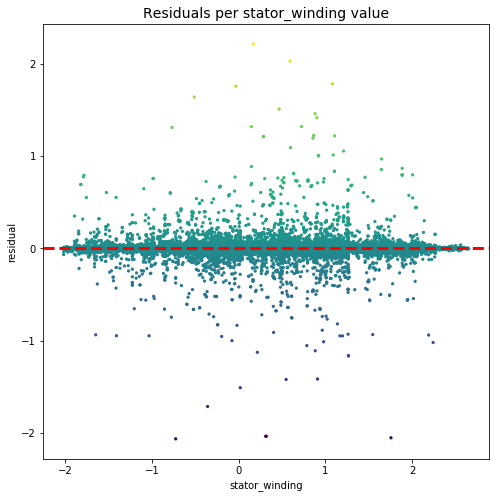

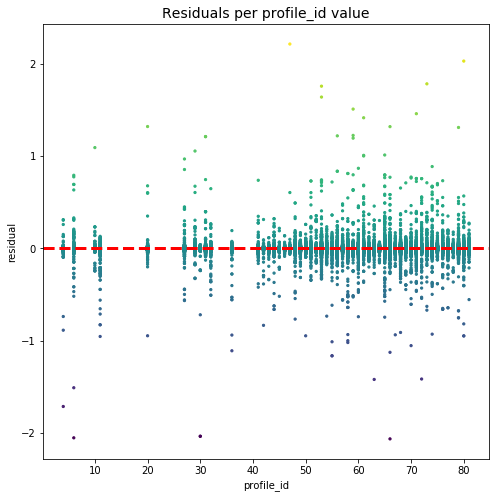

In [0]:
y_pred = tree_model.predict(X_test)

df_residuals = pd.DataFrame({'y_truth': y_test, 'y_pred': y_pred})
df_residuals['residuals'] = df_residuals.y_truth - df_residuals.y_pred

for col in X_test.columns:
    plt.figure(figsize=(8, 8))    
    plt.scatter(x=X_test[col], y=df_residuals.residuals, c=df_residuals.residuals, marker='o', s=5, cmap='viridis')
    plt.axhline(0, c='r', ls='--', lw=3)
    plt.xlabel(col)
    plt.ylabel('residual')
    plt.title(f'Residuals per {col} value', fontsize=14)
    plt.show()

### (7) Worst Predictions Analysis [Regression Tree]

In [0]:
#Identify worsts predictions
def get_worst_pred(model, X, y):
    y_pred = model.predict(X)
    data = pd.DataFrame({'y_pred': y_pred}, index=X.index)
    data['y_truth'] = y
    data['abs_residual'] = (data.y_truth - data.y_pred).abs()

    data.sort_values(by=['abs_residual'], ascending=False, inplace=True)
    
    plt.figure(figsize=(14, 14))    
    plt.scatter(x=data.y_truth, y=data.y_pred, c=data.abs_residual, marker='o', s=5, cmap='viridis')
    plt.plot(data.y_truth, data.y_truth, c='r', ls='--', lw=1)
    plt.colorbar()
    plt.title('Observed VS Predicted Values', fontsize=14)
    plt.show()
    
    return data

df_worst_pred = get_worst_pred(tree_model, X_test, y_test)

In [0]:
df_worst_pred.head(10)

y_pred   y_truth  abs_residual
369228 -1.415465  0.802500      2.217965
699442  1.261776 -0.803586      2.065362
64956   2.215383  0.161454      2.053929
218114  1.388071 -0.648932      2.037003
218113  1.388071 -0.648477      2.036548
962036 -1.617191  0.415824      2.033015
821536 -0.919159  0.866714      1.785873
426668 -2.171527 -0.410753      1.760774
26342   1.542800 -0.171012      1.713813
426453 -2.171527 -0.528863      1.642664

**Check features for worst predicted points**

In [0]:
# Given the filter above (for 1 or 0 errors), show the worst offenders
index_to_debug = df_worst_pred.index
points_to_debug = X_test.loc[index_to_debug].head(10)
points_to_debug.style.background_gradient(cmap='summer', low=2).set_caption('For worsts errors, show the features we use')

**Example of debugging**

In [0]:
# Example of debugging
point_to_debug = X_test.loc[index_to_debug[0]]
print('Debugging:', point_to_debug, 
      'with scores:', df_worst_pred.loc[point_to_debug.name], 
      sep='\n\n')

Debugging:

ambient            -0.995456
coolant             0.327082
u_d                 0.686598
u_q                -0.397284
motor_speed        -0.706349
i_d                 0.784535
i_q                -1.081122
stator_yoke         0.419095
stator_tooth        0.338240
stator_winding      0.169409
profile_id         47.000000
time              855.000000
Name: 369228, dtype: float64

with scores:

y_pred         -1.415465
y_truth         0.802500
abs_residual    2.217965
Name: 369228, dtype: float64


### (8) Model vs Dummy Classifier [Regression Tree]

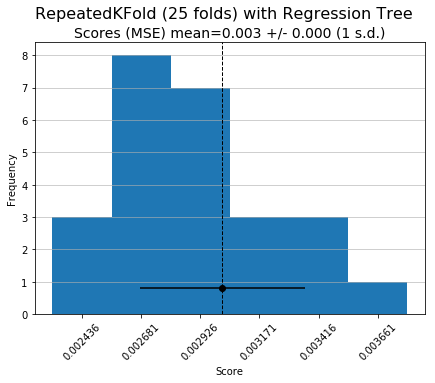

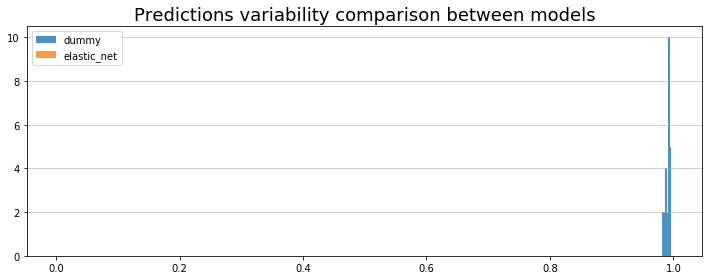

In [0]:
scores = {'dummy': cross_valid_report(dummy_model, X_test, y_test, model_type=f'DummyClassifier'),
          'elastic_net': cross_valid_report(elastic_model.best_estimator_, X_test, y_test, model_type=f'Elastic Net'),
          'regression_tree': cross_valid_report(tree_model.best_estimator_, X_test, y_test, model_type='Regression Tree')}

df_scores = pd.DataFrame(scores)


# Plot scores for every model
plt.figure(figsize=(10, 4))
colors = plt.rcParams["axes.prop_cycle"]()

# A subplot for every label
for i, col in enumerate(df_scores.columns):
    tmp = df_scores[col]

    # Histogram
    plt.hist(tmp, 
             bins='auto',
             align='left',
             label=f'{col}',
             color=next(colors)['color'], 
             alpha=0.8)

plt.grid(axis='y', alpha=0.75)
plt.title(f'Predictions variability comparison between models', fontsize=18)
plt.legend(loc='auto')
plt.tight_layout()
plt.show()

In [0]:
########################################
# Only Elastic Net and Regression Tree #
########################################

# Plot scores for every model
plt.figure(figsize=(8, 4))
colors = plt.rcParams["axes.prop_cycle"]()

# A subplot for every label
for i, col in enumerate(df_scores.drop(columns=['dummy']).columns):
    tmp = df_scores[col]

    # Histogram
    plt.hist(tmp, 
             bins='auto',
             align='left',
             label=f'{col}',
             color=next(colors)['color'], 
             alpha=0.8)

plt.grid(axis='y', alpha=0.75)
plt.title(f'Predictions variability comparison between models', fontsize=18)
plt.legend(loc='auto')
plt.tight_layout()
plt.show()

### (9) Model Explanation [Regression Tree]

[Qui](https://github.com/ianozsvald/data_science_delivered/blob/master/ml_explain_regression_prediction.ipynb) per maggiori dettagli.

In [0]:
Source(export_graphviz(tree_model.best_estimator_, out_file=None, feature_names=X_train.columns))

KeyboardInterrupt: ignored

In [0]:
for name, importance in zip(X_train.columns, tree_model.best_estimator_.feature_importances_):
    print('{:15s}\t:\t{:6.2%}'.format(name, importance))

## Bagging Algorithms

 In technical terms, the predictions have variance because they will be widely spread around the right answer.



```
"When random subsets of the dataset are drawn as random subsets of the samples, then this algorithm is known as Pasting. If samples are drawn with replacement, then the method is known as Bagging. When random subsets of the dataset are drawn as random subsets of the features, then the method is known as Random Subspaces."
Cit. sklearn.ensemble.BaggingRegressor documentation
```



![Bagging](https://miro.medium.com/max/1086/1*l16JAxJR5MJea12jut-FLQ.png)

### Random Forest

![Random Forest](https://miro.medium.com/max/561/1*jEGFJCm4VSG0OzoqFUQJQg.jpeg)


```
Random forest is different from the vanilla bagging in just one way. It uses a modified tree learning algorithm that inspects, at each split in the learning process, a random subset of the features. We do so to avoid the correlation between the trees. Suppose that we have a very strong predictor in the data set along with a number of other moderately strong predictors, then in the collection of bagged trees, most or all of our decision trees will use the very strong predictor for the first split! All bagged trees will look similar. Hence all the predictions from the bagged trees will be highly correlated. Correlated
predictors cannot help in improving the accuracy of prediction. By taking a random subset of features, Random Forests systematically avoids correlation and improves model’s performance.
```



![Random Forest](https://miro.medium.com/max/884/1*5vlUF8FRR6flPPWK4wt-Kw.png)

**Feature Importance**


```
One problem with computing fully grown trees is that we cannot easily interpret the results. And it is no longer clear which variables are important to the relationship. Calculating drop in the error function for a variable at each split point gives us an idea of feature importance. It means that we record the total amount that the error is decreased due to splits over a given predictor, averaged over all bagged trees. A large value then indicates an important predictor. In regression problems this may be the drop in residual sum of squares and in classification this might be the Gini score.
```



In [0]:
sklearn.ensemble.BaggingRegressor

In [0]:
sklearn.ensemble.RandomForestRegressor

## Boosting Algorithms

**The basic idea behind boosting is converting many weak learners to form a single strong learner.**

**Weak learner** is a learner that will always do better than chance, when it tries to label the data, no matter what the distribution over the training data is. Doing better than chance means we are always going to have an error rate which is less than 1/2. This means that the learner algorithm is always going to learn something, and will not always be completely accurate i.e., it is weak and poor when it comes to learning the relationships between inputs and target. It also means a rule formed using a single predictor/classifier is not powerful individually.
We start finding weak learners in the dataset by making some distributions and forming small decision trees from them. The size of the tree is tuned using number of splits it has. Often 1 works well, where each tree consists of a single split. Such trees are known as Decision Stumps.
Another parameter boosting takes is the number of iterations or number of trees in this case. Additionally, it assigns weights to the inputs based on whether they were correctly predicted/classified or not. Lets look at the algorithm.

![Boosting Trees](https://miro.medium.com/max/552/1*OCbjhFH6kfquNOO3RGE9Aw.png)

In [0]:
sklearn.ensemble.AdaBoostRegressor

In [0]:
sklearn.ensemble.GradientBoostingRegressor

## Esercizi


1.    > Utilizzare la funzione [`sklearn.preprocessing.PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) per produrre nuove variabili esplicative da utilizzare per lo sviluppo della regressione lineare.

2.   > Sviluppare il punto `(10) Model Explanation` anche per la regressione lineare.

3. Individuare con dei grafici i motivi per i quali la regressione lineare ha dato pessimi risultati.

4.   > Mostrare come le previsioni dell'albero decisionale variano rispetto ad ogni variabile esplicativa (grafico $(x_i, \hat{y})$).

## Fonti

> `"Python Data Science Handbook: Tools and Techniques for Developers"`, Jake VanderPlas

> `"Data Mining"`, Charu C. Aggarwal

> `"Outlier Analysis"`, Charu C. Aggarwal

> `"Pattern Recognition and Machine Learning"`, Christopher M. Bishop


# Completed Notebook

In [0]:
import datetime
print('Completed running this Notebook at:', datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

Completed running this Notebook at: 2019-10-16 10:49:51
